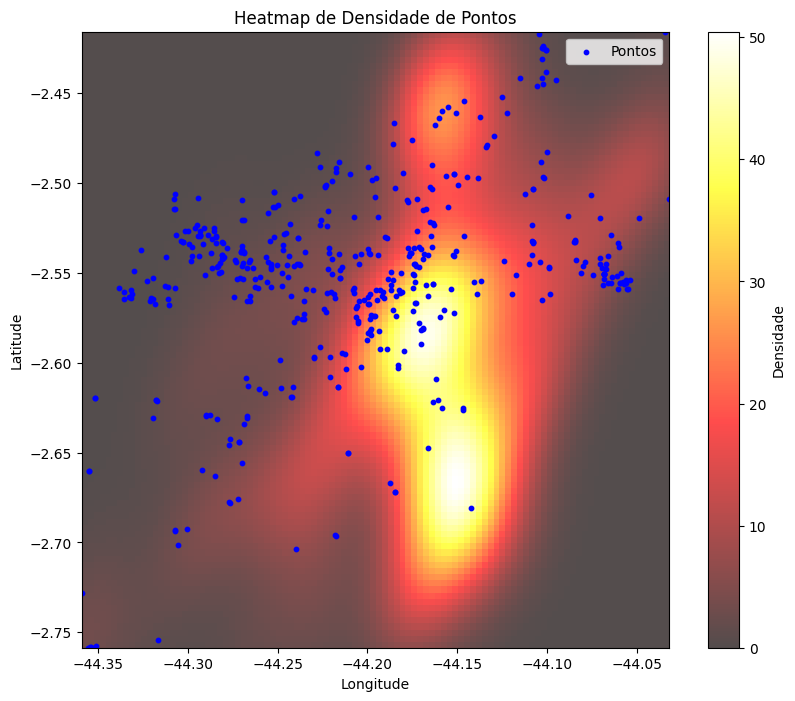

In [7]:
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Carregar o shapefile com GeoPandas
gdf = gpd.read_file("../data/escolas_publicas_ilha_maranhao.zip")


gdf.dropna(subset=['geometry'],inplace=True)

# Garantir que o GeoDataFrame está em EPSG:4326
if gdf.crs.to_string() != "EPSG:4326":
    gdf = gdf.to_crs("EPSG:4326")

# Extrair as coordenadas (longitude e latitude)
coords = np.array([(point.x, point.y) for point in gdf.geometry])

# Calcular a densidade de Kernel (Kernel Density Estimation - KDE)
kde = gaussian_kde(coords.T)
x_min, y_min = coords.min(axis=0)
x_max, y_max = coords.max(axis=0)

# Criar uma grade para avaliar a densidade
x, y = np.mgrid[x_min:x_max:100j, y_min:y_max:100j]
positions = np.vstack([x.ravel(), y.ravel()])
density = np.reshape(kde(positions).T, x.shape)

# Visualizar o Heatmap com Matplotlib
plt.figure(figsize=(10, 8))
plt.imshow(
    density, 
    extent=[x_min, x_max, y_min, y_max],
    origin='lower',
    cmap='hot', 
    alpha=0.7
)
plt.colorbar(label="Densidade")
plt.title("Heatmap de Densidade de Pontos")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.scatter(coords[:, 0], coords[:, 1], c='blue', s=10, label='Pontos')
plt.legend()
plt.show()


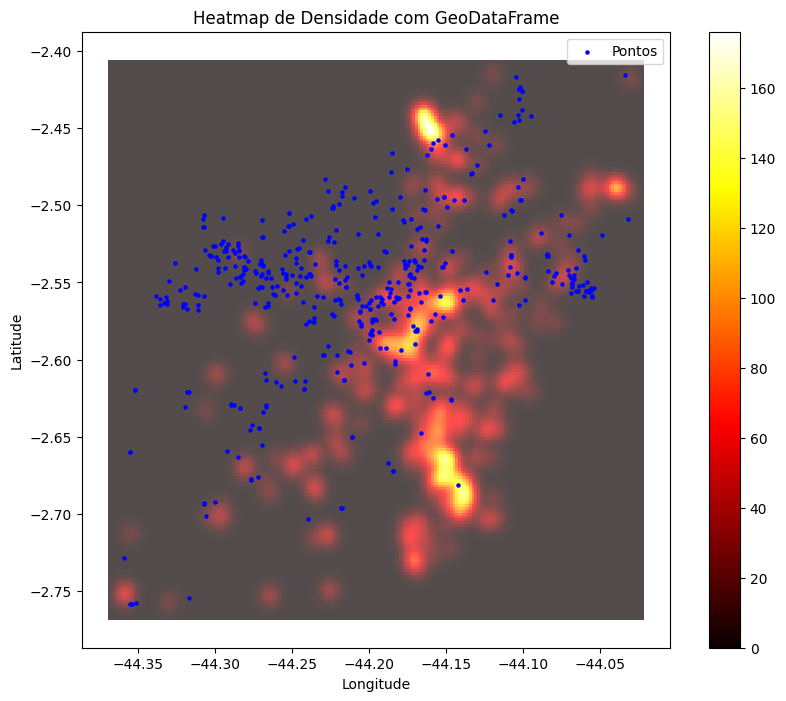

In [11]:
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
from sklearn.neighbors import KernelDensity

# Carregar o shapefile com GeoPandas
gdf = gpd.read_file("../data/escolas_publicas_ilha_maranhao.zip")


gdf.dropna(subset=['geometry'],inplace=True)

# Garantir que o GeoDataFrame está em EPSG:4326
if gdf.crs.to_string() != "EPSG:4326":
    gdf = gdf.to_crs("EPSG:4326")


# Ajustar a extensão do mapa (com margem)
x_min, y_min = coords[:, 0].min(), coords[:, 1].min()
x_max, y_max = coords[:, 0].max(), coords[:, 1].max()
margem = 0.01
x_min -= margem
y_min -= margem
x_max += margem
y_max += margem

# Criar a grade de avaliação
x = np.linspace(x_min, x_max, 200)
y = np.linspace(y_min, y_max, 200)
xv, yv = np.meshgrid(x, y)
positions = np.vstack([xv.ravel(), yv.ravel()])

# Calcular KDE com largura de banda ajustada
bandwidth = 0.005  # Ajuste conforme necessário
kde = KernelDensity(bandwidth=bandwidth, kernel='gaussian')
kde.fit(coords)
density = np.exp(kde.score_samples(positions.T)).reshape(xv.shape)

# Criar polígonos para cada célula da grade
polygons = []
densities = []

# Iterar sobre a grade e criar polígonos para cada célula
for i in range(xv.shape[0] - 1):
    for j in range(xv.shape[1] - 1):
        # Coordenadas do polígono
        polygon = Polygon([
            (x[i], y[j]),
            (x[i + 1], y[j]),
            (x[i + 1], y[j + 1]),
            (x[i], y[j + 1])
        ])
        polygons.append(polygon)
        densities.append(density[i, j])

# Criar um GeoDataFrame com os polígonos e a densidade
heatmap_gdf = gpd.GeoDataFrame({'density': densities, 'geometry': polygons}, crs="EPSG:4326")

# Plotar o Heatmap com GeoPandas
fig, ax = plt.subplots(figsize=(10, 8))
heatmap_gdf.plot(column='density', cmap='hot', ax=ax, legend=True, alpha=0.7)
gdf.plot(ax=ax, color='blue', markersize=5, label='Pontos')
ax.set_title("Heatmap de Densidade com GeoDataFrame")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.legend()
plt.show()


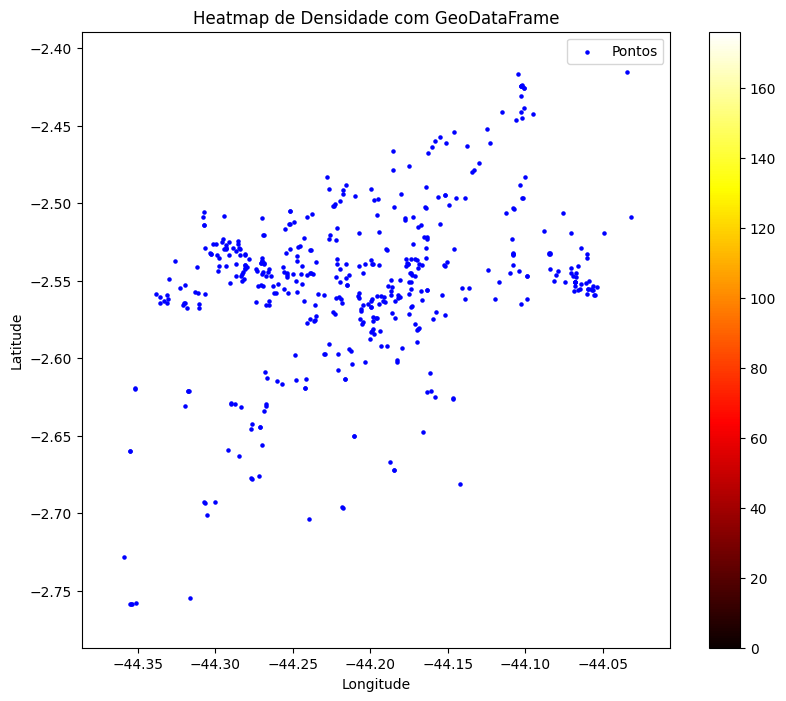

In [12]:
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
from sklearn.neighbors import KernelDensity

# Carregar o shapefile com GeoPandas
gdf = gpd.read_file("../data/escolas_publicas_ilha_maranhao.zip")


gdf.dropna(subset=['geometry'],inplace=True)

# Garantir que o GeoDataFrame está em EPSG:4326
if gdf.crs.to_string() != "EPSG:4326":
    gdf = gdf.to_crs("EPSG:4326")

# Extrair coordenadas (ordem correta: longitude, latitude)
coords = np.array([(point.x, point.y) for point in gdf.geometry])

# Ajustar a extensão do mapa (com margem)
x_min, y_min = coords[:, 0].min(), coords[:, 1].min()
x_max, y_max = coords[:, 0].max(), coords[:, 1].max()
margem = 0.01
x_min -= margem
y_min -= margem
x_max += margem
y_max += margem

# Criar a grade de avaliação
x = np.linspace(x_min, x_max, 200)
y = np.linspace(y_min, y_max, 200)
xv, yv = np.meshgrid(x, y)
positions = np.vstack([xv.ravel(), yv.ravel()])

# Calcular KDE com largura de banda ajustada
bandwidth = 0.005  # Ajuste conforme necessário
kde = KernelDensity(bandwidth=bandwidth, kernel='gaussian')
kde.fit(coords)
density = np.exp(kde.score_samples(positions.T)).reshape(xv.shape)

# Criar polígonos para cada célula da grade
polygons = []
densities = []

# Iterar sobre a grade e criar polígonos para cada célula
for i in range(xv.shape[0] - 1):
    for j in range(xv.shape[1] - 1):
        # Coordenadas dos cantos da célula
        x0, x1 = xv[i, j], xv[i + 1, j]
        y0, y1 = yv[i, j], yv[i, j + 1]
        
        # Criar polígono para a célula
        polygon = Polygon([
            (x0, y0),
            (x1, y0),
            (x1, y1),
            (x0, y1),
        ])
        polygons.append(polygon)
        densities.append(density[i, j])

# Criar um GeoDataFrame com os polígonos e a densidade
heatmap_gdf = gpd.GeoDataFrame({'density': densities, 'geometry': polygons}, crs="EPSG:4326")

# Plotar o Heatmap com GeoPandas
fig, ax = plt.subplots(figsize=(10, 8))
heatmap_gdf.plot(column='density', cmap='hot', ax=ax, legend=True, alpha=0.7)
gdf.plot(ax=ax, color='blue', markersize=5, label='Pontos')
ax.set_title("Heatmap de Densidade com GeoDataFrame")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.legend()
plt.show()
